   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.5 MB/s eta 0:00:00


2026-01-12 08:56:33.240 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 08:56:33.243 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-01-12 08:56:33.247 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 08:56:33.453 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-01-12 08:56:33.454 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 08:56:33.455 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 08:56:33.457 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runnin

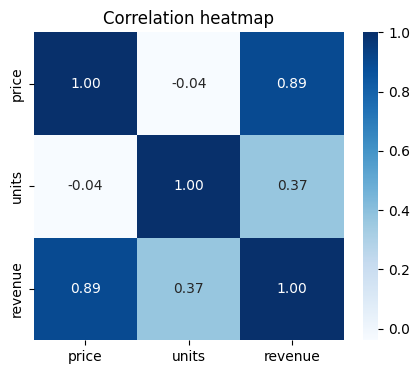

In [3]:
import sys

import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

st.set_page_config(page_title="Analytics Dashboard", layout="wide")

# -----------------------------
# Data loading and preprocessing
# -----------------------------
@st.cache_data
def load_data(uploaded_file=None, default_path=None):
    if uploaded_file is not None:
        df = pd.read_csv(uploaded_file)
    elif default_path is not None:
        df = pd.read_csv(default_path)
    else:
        # Fallback synthetic data (replace with your source)
        np.random.seed(42)
        df = pd.DataFrame({
            "date": pd.date_range("2024-01-01", periods=180, freq="D"),
            "category": np.random.choice(["A", "B", "C"], size=180),
            "region": np.random.choice(["North", "South", "East", "West"], size=180),
            "price": np.random.gamma(4, 20, size=180).round(2),
            "units": np.random.poisson(20, size=180),
        })
        df["revenue"] = (df["price"] * df["units"]).round(2)
    # Basic cleaning
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df

def filter_data(df, category=None, region=None, date_range=None):
    dff = df.copy()
    if category and "category" in dff.columns:
        dff = dff[dff["category"].isin(category)]
    if region and "region" in dff.columns:
        dff = dff[dff["region"].isin(region)]
    if date_range and "date" in dff.columns and all(date_range):
        start, end = date_range
        dff = dff[(dff["date"] >= pd.to_datetime(start)) & (dff["date"] <= pd.to_datetime(end))]
    return dff

# -----------------------------
# Chart functions (replace with your own)
# -----------------------------
def line_revenue_over_time(df):
    fig = px.line(df.sort_values("date"), x="date", y="revenue", color="category",
                  title="Revenue over time by category")
    fig.update_layout(legend_title_text="Category")
    return fig

def bar_units_by_region(df):
    agg = df.groupby("region", as_index=False)["units"].sum()
    fig = px.bar(agg, x="region", y="units", title="Total units by region", text="units")
    fig.update_traces(textposition="outside")
    return fig

def box_price_by_category(df):
    fig = px.box(df, x="category", y="price", color="category",
                 title="Price distribution by category")
    return fig

def heatmap_corr(df, cols=("price", "units", "revenue")):
    use_cols = [c for c in cols if c in df.columns]
    corr = df[use_cols].corr()
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(corr, annot=True, cmap="Blues", ax=ax, fmt=".2f")
    ax.set_title("Correlation heatmap")
    st.pyplot(fig)

def scatter_price_units(df):
    fig = px.scatter(df, x="price", y="units", color="category",
                     trendline="ols", title="Price vs Units (with trendline)")
    return fig

def treemap_revenue(df):
    agg = df.groupby(["region", "category"], as_index=False)["revenue"].sum()
    fig = px.treemap(agg, path=["region", "category"], values="revenue",
                     title="Revenue treemap by region and category")
    return fig

# -----------------------------
# Sidebar controls
# -----------------------------
def sidebar_controls(df):
    st.sidebar.header("Filters")
    uploaded = st.sidebar.file_uploader("Upload CSV (optional)", type=["csv"])
    # Reload data if uploaded
    if uploaded is not None:
        df = load_data(uploaded_file=uploaded)

    categories = sorted(df["category"].dropna().unique()) if "category" in df.columns else []
    regions = sorted(df["region"].dropna().unique()) if "region" in df.columns else []

    sel_cat = st.sidebar.multiselect("Category", options=categories, default=categories)
    sel_reg = st.sidebar.multiselect("Region", options=regions, default=regions)

    if "date" in df.columns:
        min_date, max_date = df["date"].min(), df["date"].max()
        sel_date = st.sidebar.date_input("Date range", value=(min_date, max_date))
        if isinstance(sel_date, tuple) and len(sel_date) == 2:
            date_range = sel_date
        else:
            date_range = (min_date, max_date)
    else:
        date_range = None

    return df, sel_cat, sel_reg, date_range

# -----------------------------
# KPI cards
# -----------------------------
def kpi_row(df):
    col1, col2, col3, col4 = st.columns(4)
    with col1:
        st.metric(label="Total revenue", value=f"{df['revenue'].sum():,.0f}")
    with col2:
        st.metric(label="Total units", value=f"{df['units'].sum():,.0f}")
    with col3:
        st.metric(label="Avg price", value=f"{df['price'].mean():,.2f}")
    with col4:
        if "date" in df.columns:
            st.metric(label="Periods", value=df["date"].nunique())

# -----------------------------
# Main layout
# -----------------------------
def main():
    st.title("Analytics Dashboard")
    st.caption("Compile and deploy all graphs in a single Streamlit app.")

    # Initial data load (replace default_path with your CSV if needed)
    df = load_data(default_path=None)

    # Sidebar filters
    df, sel_cat, sel_reg, date_range = sidebar_controls(df)
    dff = filter_data(df, category=sel_cat, region=sel_reg, date_range=date_range)

    # KPIs
    st.subheader("Key metrics")
    kpi_row(dff)

    # Row 1: Time series + Bar
    st.subheader("Performance overview")
    c1, c2 = st.columns((2, 1))
    with c1:
        st.plotly_chart(line_revenue_over_time(dff), use_container_width=True)
    with c2:
        st.plotly_chart(bar_units_by_region(dff), use_container_width=True)

    # Row 2: Distribution + Correlation
    st.subheader("Distribution and relationships")
    c3, c4 = st.columns((1, 1))
    with c3:
        st.plotly_chart(box_price_by_category(dff), use_container_width=True)
    with c4:
        heatmap_corr(dff)

    # Row 3: Scatter + Treemap
    st.subheader("Drivers and composition")
    c5, c6 = st.columns((1, 1))
    with c5:
        st.plotly_chart(scatter_price_units(dff), use_container_width=True)
    with c6:
        st.plotly_chart(treemap_revenue(dff), use_container_width=True)

    # Raw data (optional)
    with st.expander("View filtered data"):
        st.dataframe(dff, use_container_width=True)

    # Download filtered data
    csv = dff.to_csv(index=False).encode("utf-8")
    st.download_button("Download filtered CSV", data=csv, file_name="filtered_data.csv", mime="text/csv")

if __name__ == "__main__":
    main()